# Stock Price Simulation with Geometric Brownian Motion

Thanks to the unpredictability of financial markets, simulating stock prices plays an important role in the valuation of many derivatives, such as options. Due to the
aforementioned randomness in price movement, these simulations rely on stochastic differential equations (SDE).

A stochastic process is said to follow the Geometric Brownian Motion (GBM) when it
satisfies the following SDE:

*dS = μ * S * dt + σ * Sd * Wt*

Here, we have the following:
- S: Stock price
- μ: The drift coefficient, that is, the average return over a given period or the
- instantaneous expected return
- σ: The diffusion coefficient, that is, how much volatility is in the drift
- Wt: The Brownian Motion

Brownian increments are calculated as a product of a Standard Normal random variable (rv ∼ N(0,1)) and the square root of the time
increment. Another way to say this is that the Brownian increment comes from rv ∼ N(0,t),
where t is the time increment. We obtain the Brownian path by taking the cumulative sum of the Brownian increments.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

In [3]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 146 rows of data.


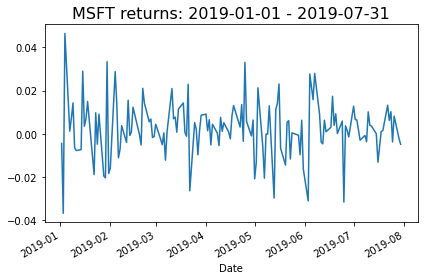

Average return: 0.24%


In [4]:
# Calculate daily returns

adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

In [5]:
# Split data to train and test datasets

train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

In [11]:
# Specify parameters of the simulation

T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1]]
N_SIM = 100
mu = train.mean()
sigma = train.std()

In [12]:
# Define function used for the simulations

def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

In [13]:
# Run the simulation
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

[]

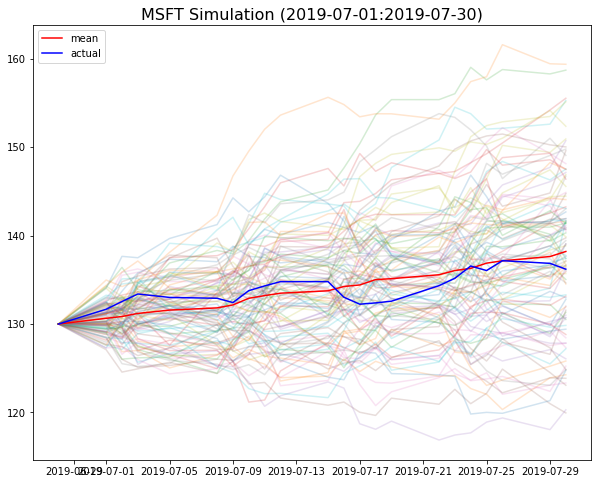

In [30]:
# Plot simulation results

# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.rcParams["figure.figsize"] = (8,5)

plt.plot()

There are some statistical methods that make working with Monte Carlo simulations easier (higher accuracy, faster computations). One of them is a variance reduction method called
antithetic variates. In this approach, we try to reduce the variance of the estimator by introducing negative dependence between pairs of random draws

The advantages of this approach are:
- Reduction (by half) of the number of Standard Normal samples to be drawn in order to generate N paths
- Reduction of the sample path variance, while at the same time, improving the accuracy

In [31]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

334 µs ± 32.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

In [33]:
# simulations without antithetic variables
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

184 µs ± 31.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [34]:
# simulations with antithetic variables
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

154 µs ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
